<h1><b>Preprocessing and augmentation</b></h1>

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders

In [3]:
splitfolders.ratio(
    'dataset',
    output='train_val_test',
    seed=42,
    ratio=(0.7, 0.15, 0.15),
    group_prefix=None,
    move=False
)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train_generator = train_datagen.flow_from_directory(
    'train_val_test/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'train_val_test/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'train_val_test/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1354 images belonging to 15 classes.
Found 284 images belonging to 15 classes.
Found 306 images belonging to 15 classes.


In [6]:
from tensorflow.keras.applications.efficientnet import preprocess_input
train_generator = preprocess_input(train_generator)
val_generator = preprocess_input(val_generator)

In [7]:
import json
with open('class_names.json', 'w') as f:
    json.dump(test_generator.class_indices, f)

<h1><b>Build the model with transfer learning</b></h1>

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [9]:
 #load pre-trained model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

In [10]:
from tensorflow.keras.regularizers import l2

#custom layers
inputs = base_model.input
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
outputs = Dense(15, activation='softmax')(x)

model = Model(inputs, outputs)

In [11]:
#complie
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

<h1><b>Train the model</b></h1>

In [ ]:
!pip install scikit-learn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/20
42/42 [==============================] - 30s 383ms/step - loss: 2.0721 - accuracy: 0.5182 - val_loss: 0.8623 - val_accuracy: 0.9258
Epoch 2/20
42/42 [==============================] - 13s 299ms/step - loss: 1.0773 - accuracy: 0.8222 - val_loss: 0.6115 - val_accuracy: 0.9688
Epoch 3/20
42/42 [==============================] - 13s 297ms/step - loss: 0.9151 - accuracy: 0.8593 - val_loss: 0.5853 - val_accuracy: 0.9609
Epoch 4/20
42/42 [==============================] - 13s 297ms/step - loss: 0.8178 - accuracy: 0.8722 - val_loss: 0.5295 - val_accuracy: 0.9766
Epoch 5/20
42/42 [==============================] - 12s 293ms/step - loss: 0.7261 - accuracy: 0.9107 - val_loss: 0.4847 - val_accuracy: 0.9883
Epoch 6/20
42/42 [==============================] - 12s 292ms/step - loss: 0.7056 - accuracy: 0.9009 - val_loss: 0.4675 - val_accuracy: 0.9883
Epoch 7/20
42/42 [==============================] - 12s 289ms/step - loss: 0.6634 - accuracy: 0.9145 - val_loss: 0.4392 - val_accuracy: 0.9922

<h1><b>Fine tuning</b></h1>

In [14]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

Epoch 1/30
42/42 [==============================] - 19s 317ms/step - loss: 0.6120 - accuracy: 0.8986 - val_loss: 0.2897 - val_accuracy: 0.9961
Epoch 2/30
42/42 [==============================] - 13s 314ms/step - loss: 0.4642 - accuracy: 0.9440 - val_loss: 0.2790 - val_accuracy: 1.0000
Epoch 3/30
42/42 [==============================] - 13s 316ms/step - loss: 0.3860 - accuracy: 0.9652 - val_loss: 0.2738 - val_accuracy: 1.0000
Epoch 4/30
42/42 [==============================] - 14s 328ms/step - loss: 0.3716 - accuracy: 0.9682 - val_loss: 0.2698 - val_accuracy: 1.0000
Epoch 5/30
42/42 [==============================] - 14s 336ms/step - loss: 0.3620 - accuracy: 0.9713 - val_loss: 0.2672 - val_accuracy: 1.0000
Epoch 6/30
42/42 [==============================] - 14s 332ms/step - loss: 0.3388 - accuracy: 0.9766 - val_loss: 0.2674 - val_accuracy: 1.0000
Epoch 7/30
42/42 [==============================] - 15s 357ms/step - loss: 0.3262 - accuracy: 0.9796 - val_loss: 0.2672 - val_accuracy: 0.9961

<h1><b>Plot & Evaluate

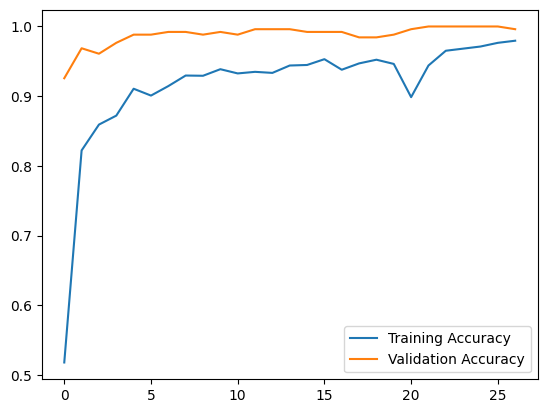

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [18]:
# Evaluate
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

9/9 [==============================] - 2s 210ms/step - loss: 0.2664 - accuracy: 1.0000
Test Accuracy: 100.00%


In [19]:
import numpy as np
preds = model.predict(test_generator, steps=test_generator.samples // 32 + 1)
pred_classes = np.argmax(preds, axis=1)
true_classes = test_generator.classes
from sklearn.metrics import classification_report
print(classification_report(true_classes, pred_classes, target_names=test_generator.class_indices.keys()))

10/10 [==============================] - 2s 137ms/step
              precision    recall  f1-score   support

        Bear       1.00      1.00      1.00        20
        Bird       1.00      1.00      1.00        22
         Cat       1.00      1.00      1.00        19
         Cow       1.00      1.00      1.00        21
        Deer       1.00      1.00      1.00        20
         Dog       1.00      1.00      1.00        19
     Dolphin       1.00      1.00      1.00        20
    Elephant       1.00      1.00      1.00        21
     Giraffe       1.00      1.00      1.00        20
       Horse       1.00      1.00      1.00        20
    Kangaroo       1.00      1.00      1.00        20
        Lion       1.00      1.00      1.00        21
       Panda       1.00      1.00      1.00        21
       Tiger       1.00      1.00      1.00        20
       Zebra       1.00      1.00      1.00        22

    accuracy                           1.00       306
   macro avg       1.00  

In [36]:
model.save('animal_classifier_model.h5')